In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, GlobalAveragePooling2D, Embedding, LSTM, Bidirectional, Concatenate, Flatten, Dropout
)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [13]:
IMG_SIZE = (224, 224)
MAX_SEQ_LENGTH = 1000
VOCAB_SIZE = 50000
EMBEDDING_DIM = 100
BATCH_SIZE = 32

In [3]:
train_data = pd.read_csv("C:\\Users\\jasra\\OneDrive\\Desktop\\MAJOR PROJECT\\MultiOFF_Dataset\\Split Dataset\\Training_meme_dataset.csv")
val_data = pd.read_csv("C:\\Users\\jasra\\OneDrive\\Desktop\\MAJOR PROJECT\\MultiOFF_Dataset\\Split Dataset\\Validation_meme_dataset.csv")
test_data = pd.read_csv("C:\\Users\\jasra\\OneDrive\\Desktop\\MAJOR PROJECT\\MultiOFF_Dataset\\Split Dataset\\Testing_meme_dataset.csv")

In [4]:
# Preprocess Labels
label_encoder = LabelEncoder()
train_data["label"] = label_encoder.fit_transform(train_data["label"])
val_data["label"] = label_encoder.transform(val_data["label"])
test_data["label"] = label_encoder.transform(test_data["label"])

In [6]:
def preprocess_images(image_dir, image_list):
    images = []
    for img_name in image_list:
        img_path = os.path.join(image_dir, img_name)
        img = load_img(img_path, target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    return np.array(images)

In [7]:
train_images = preprocess_images("C:/Users/jasra/OneDrive/Desktop/MAJOR PROJECT/MultiOFF_Dataset/Labelled Images/", train_data["image_name"])
val_images = preprocess_images("C:/Users/jasra/OneDrive/Desktop/MAJOR PROJECT/MultiOFF_Dataset/Labelled Images/", val_data["image_name"])
test_images = preprocess_images("C:/Users/jasra/OneDrive/Desktop/MAJOR PROJECT/MultiOFF_Dataset/Labelled Images/", test_data["image_name"])

In [10]:
import re
from nltk.corpus import stopwords
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
EMAIL = re.compile(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}')
NUMBERS_RE = re.compile(r'\d+')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):  #preprocessing of text 
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = EMAIL.sub('', text)
    text = NUMBERS_RE.sub('', text)  # Remove numbers
    text = REPLACE_BY_SPACE_RE.sub(' ',text)
    text = BAD_SYMBOLS_RE.sub('',text)    
    # text = text.replace('x','')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    
    return text

In [11]:
train_data['sentence'] = train_data['sentence'].apply(clean_text)
test_data['sentence'] = test_data['sentence'].apply(clean_text)
val_data['sentence'] = val_data['sentence'].apply(clean_text)

In [14]:
# Preprocess Text
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(train_data["sentence"])

In [15]:
train_text = pad_sequences(tokenizer.texts_to_sequences(train_data["sentence"]), maxlen=MAX_SEQ_LENGTH)
val_text = pad_sequences(tokenizer.texts_to_sequences(val_data["sentence"]), maxlen=MAX_SEQ_LENGTH)
test_text = pad_sequences(tokenizer.texts_to_sequences(test_data["sentence"]), maxlen=MAX_SEQ_LENGTH)

In [17]:
image_input = Input(shape=(224, 224, 3))
base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=image_input)
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dense(64, activation="relu")(x)
image_output = Dense(1, activation="sigmoid")(x) 
image_model = Model(inputs=image_input, outputs=image_output)

In [18]:
from tensorflow.keras.optimizers import Adam
# Compile Image Model
image_model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

In [19]:
image_history = image_model.fit(
    train_images, 
    train_data["label"], 
    validation_data=(val_images, val_data["label"]), 
    epochs=7, 
    batch_size=32
)

Epoch 1/7
14/14 [==============================] - 115s 7s/step - loss: 0.9306 - accuracy: 0.4921 - val_loss: 15749.9795 - val_accuracy: 0.6107
Epoch 2/7
14/14 [==============================] - 107s 8s/step - loss: 0.7107 - accuracy: 0.5843 - val_loss: 14976.2432 - val_accuracy: 0.3893
Epoch 3/7
14/14 [==============================] - 105s 8s/step - loss: 0.6947 - accuracy: 0.6067 - val_loss: 3097.2295 - val_accuracy: 0.3893
Epoch 4/7
14/14 [==============================] - 103s 7s/step - loss: 0.6611 - accuracy: 0.5978 - val_loss: 123.9914 - val_accuracy: 0.6107
Epoch 5/7
14/14 [==============================] - 104s 7s/step - loss: 0.6731 - accuracy: 0.6247 - val_loss: 348.0192 - val_accuracy: 0.3893
Epoch 6/7
14/14 [==============================] - 101s 7s/step - loss: 0.6496 - accuracy: 0.6809 - val_loss: 0.6764 - val_accuracy: 0.6107
Epoch 7/7
14/14 [==============================] - 107s 8s/step - loss: 0.6469 - accuracy: 0.6517 - val_loss: 26.1597 - val_accuracy: 0.6107


5/5 [==============================] - 8s 1s/step


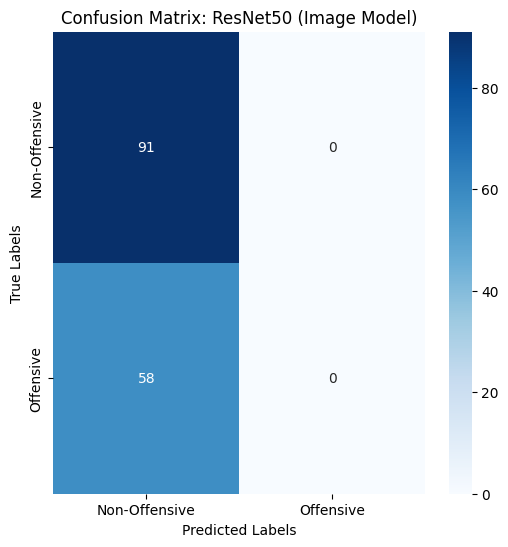

In [20]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

image_predictions = image_model.predict(test_images)
image_predictions_binary = (image_predictions > 0.5).astype(int)  # Convert probabilities to 0 or 1

# Compute Confusion Matrix
image_conf_matrix = confusion_matrix(test_data["label"], image_predictions_binary)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(image_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Offensive", "Offensive"], yticklabels=["Non-Offensive", "Offensive"])
plt.title("Confusion Matrix: ResNet50 (Image Model)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [22]:
image_model.save("image_model.h5")

In [23]:
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

text_input = Input(shape=(MAX_SEQ_LENGTH,))
embedding_layer = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQ_LENGTH)(text_input)
x = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(128))(x)
x = Dense(64, activation="relu")(x)
text_output = Dense(1, activation="sigmoid")(x)  # Binary classification
text_model = Model(inputs=text_input, outputs=text_output)

# Compile Text Model
text_model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])


In [24]:
text_history = text_model.fit(
    train_text, 
    train_data["label"], 
    validation_data=(val_text, val_data["label"]), 
    epochs=10, 
    batch_size=32
)

Epoch 1/10
14/14 [==============================] - 65s 4s/step - loss: 0.6854 - accuracy: 0.5753 - val_loss: 0.6727 - val_accuracy: 0.6107
Epoch 2/10
14/14 [==============================] - 62s 5s/step - loss: 0.6734 - accuracy: 0.5820 - val_loss: 0.6708 - val_accuracy: 0.6107
Epoch 3/10
14/14 [==============================] - 66s 5s/step - loss: 0.4742 - accuracy: 0.7910 - val_loss: 2.3551 - val_accuracy: 0.6242
Epoch 4/10
14/14 [==============================] - 68s 5s/step - loss: 0.2251 - accuracy: 0.9281 - val_loss: 1.1911 - val_accuracy: 0.5772
Epoch 5/10
14/14 [==============================] - 66s 5s/step - loss: 0.0948 - accuracy: 0.9753 - val_loss: 1.3221 - val_accuracy: 0.5436
Epoch 6/10
14/14 [==============================] - 69s 5s/step - loss: 0.0880 - accuracy: 0.9708 - val_loss: 1.0869 - val_accuracy: 0.5101
Epoch 7/10
14/14 [==============================] - 76s 5s/step - loss: 0.0537 - accuracy: 0.9865 - val_loss: 1.7468 - val_accuracy: 0.5772
Epoch 8/10
14/14 [==

5/5 [==============================] - 5s 752ms/step


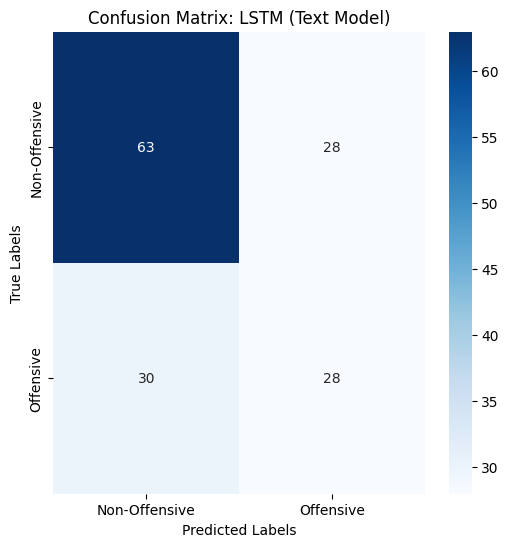

Classification Report for LSTM:
               precision    recall  f1-score   support

Non-Offensive       0.68      0.69      0.68        91
    Offensive       0.50      0.48      0.49        58

     accuracy                           0.61       149
    macro avg       0.59      0.59      0.59       149
 weighted avg       0.61      0.61      0.61       149



In [25]:
# Predict with the LSTM model
text_predictions = text_model.predict(test_text)
text_predictions_binary = (text_predictions > 0.5).astype(int)  # Convert probabilities to 0 or 1

# Compute Confusion Matrix
text_conf_matrix = confusion_matrix(test_data["label"], text_predictions_binary)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(text_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Offensive", "Offensive"], yticklabels=["Non-Offensive", "Offensive"])
plt.title("Confusion Matrix: LSTM (Text Model)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
print("Classification Report for LSTM:")
print(classification_report(test_data["label"], text_predictions_binary, target_names=["Non-Offensive", "Offensive"]))


In [26]:
text_model.save("text_model.h5")

In [27]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Concatenate

# Load Pretrained Models
pretrained_image_model = load_model("image_model.h5")
pretrained_text_model = load_model("text_model.h5")

In [28]:
# Freeze the Pretrained Models
for layer in pretrained_image_model.layers:
    layer.trainable = False
for layer in pretrained_text_model.layers:
    layer.trainable = False

In [31]:
# Combine Models
image_features = pretrained_image_model.get_layer("dense_3").output  # Adjust the layer name if necessary
text_features = pretrained_text_model.get_layer("dense_5").output  # Adjust the layer name if necessary

In [32]:
combined_features = Concatenate()([image_features, text_features])
x = Dense(128, activation="relu")(combined_features)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu")(x)
final_output = Dense(1, activation="sigmoid")(x)

# Final Multimodal Model
final_model = Model(inputs=[pretrained_image_model.input, pretrained_text_model.input], outputs=final_output)



In [33]:
# Compile Final Model
final_model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


In [34]:
# Train Final Model
final_history = final_model.fit(
    [train_images, train_text],
    train_data["label"],
    validation_data=([val_images, val_text], val_data["label"]),
    epochs=10,
    batch_size=32
)

Epoch 1/10
14/14 [==============================] - 46s 3s/step - loss: 0.6741 - accuracy: 0.7528 - val_loss: 0.6985 - val_accuracy: 0.4497
Epoch 2/10
14/14 [==============================] - 38s 3s/step - loss: 0.6617 - accuracy: 0.9393 - val_loss: 0.7002 - val_accuracy: 0.4497
Epoch 3/10
14/14 [==============================] - 38s 3s/step - loss: 0.6543 - accuracy: 0.9685 - val_loss: 0.7020 - val_accuracy: 0.4564
Epoch 4/10
14/14 [==============================] - 37s 3s/step - loss: 0.6426 - accuracy: 0.9798 - val_loss: 0.7042 - val_accuracy: 0.4631
Epoch 5/10
14/14 [==============================] - 37s 3s/step - loss: 0.6336 - accuracy: 0.9753 - val_loss: 0.7066 - val_accuracy: 0.4631
Epoch 6/10
14/14 [==============================] - 39s 3s/step - loss: 0.6226 - accuracy: 0.9865 - val_loss: 0.7093 - val_accuracy: 0.4497
Epoch 7/10
14/14 [==============================] - 40s 3s/step - loss: 0.6156 - accuracy: 0.9843 - val_loss: 0.7123 - val_accuracy: 0.4564
Epoch 8/10
14/14 [==

5/5 [==============================] - 11s 2s/step


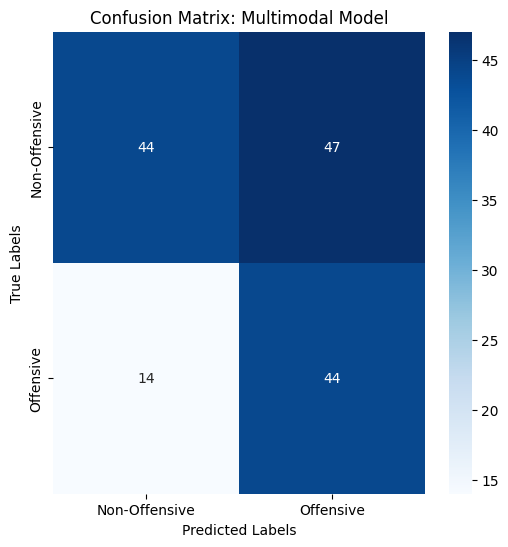

Classification Report for Multimodal Model:
               precision    recall  f1-score   support

Non-Offensive       0.76      0.48      0.59        91
    Offensive       0.48      0.76      0.59        58

     accuracy                           0.59       149
    macro avg       0.62      0.62      0.59       149
 weighted avg       0.65      0.59      0.59       149



In [35]:
# Predict with the Multimodal Model
final_predictions = final_model.predict([test_images, test_text])
final_predictions_binary = (final_predictions > 0.5).astype(int)  # Convert probabilities to 0 or 1

# Compute Confusion Matrix
final_conf_matrix = confusion_matrix(test_data["label"], final_predictions_binary)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(final_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Offensive", "Offensive"], yticklabels=["Non-Offensive", "Offensive"])
plt.title("Confusion Matrix: Multimodal Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
print("Classification Report for Multimodal Model:")
print(classification_report(test_data["label"], final_predictions_binary, target_names=["Non-Offensive", "Offensive"]))


In [36]:
final_model.save("final_model_ac59.h5")